In [13]:
import gensim
archivoModelo = 'Vectores.w2v'
archivoComentarios = 'SoloTextos.txt'
sentences = gensim.models.word2vec.Text8Corpus(archivoComentarios)

In [14]:
import multiprocessing

#Dimensionality of the resulting word vectors
num_features = 128
#Minimum word count threshold
min_word_count = 2
#Number of threads to run in parallel
num_workers = multiprocessing.cpu_count()
#Context window length
context_size = 5
#Seed for the RNG, to make the result reproducible
seed = 1

modelo = gensim.models.FastText(
    sg=1,
    seed=seed,
    workers=num_workers, 
    size=num_features, 
    min_count=min_word_count, 
    window=context_size)

modelo.build_vocab(sentences=sentences)
print("Vocabulario construido")
print("Tamaño de vocabulario de Word2Vec: ", len(modelo.wv.vocab))
#Start training the model
print("Inicio entrenamiento")
modelo.train(sentences=sentences,total_examples=modelo.corpus_count, epochs=100)
print("Fin entrenamiento")
modelo.save(archivoModelo)
print("Modelo guardado")

Vocabulario construido
Tamaño de vocabulario de Word2Vec:  6886
Inicio entrenamiento
Fin entrenamiento
Modelo guardado


In [15]:
import numpy as np

modelo = gensim.models.word2vec.Word2Vec.load(archivoModelo)  # Cargar el modelo ya entrenado
count = 10000
word_vectors_matrix = np.ndarray(shape=(count, num_features), dtype='float64')
word_list = []
i = 0
for word in modelo.wv.vocab:
    word_vectors_matrix[i] = modelo[word]
    word_list.append(word)
    i = i+1
    if i == count:
        break
print("word_vectors_matrix shape is ", word_vectors_matrix.shape)

word_vectors_matrix shape is  (10000, 128)


C:\Users\joax\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [16]:
import sklearn.manifold
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
word_vectors_matrix_2d = tsne.fit_transform(word_vectors_matrix)
print("word_vectors_matrix_2d shape is ", word_vectors_matrix_2d.shape)

word_vectors_matrix_2d shape is  (10000, 2)


In [17]:
import pandas as pd
points = pd.DataFrame(
    [
        (word, coords[0], coords[1]) 
        for word, coords in [
            (word, word_vectors_matrix_2d[word_list.index(word)])
            for word in word_list
        ]
    ],
    columns=["word", "x", "y"]
)
print("Points DataFrame built")
points.head((10))

Points DataFrame built


,word,x,y
0,salgo,30.129375,28.526299
1,#veotv,30.679928,28.278856
2,día,3.622723,-8.354141
3,más,-19.507999,-3.376188
4,@pauladelasheras,9.092766,2.870845
5,no,11.978325,5.238315
6,ayudar,11.944101,-59.103359
7,menos,17.746674,9.309682
8,besos,38.636299,15.655052
9,gracias,-11.224227,-16.195507


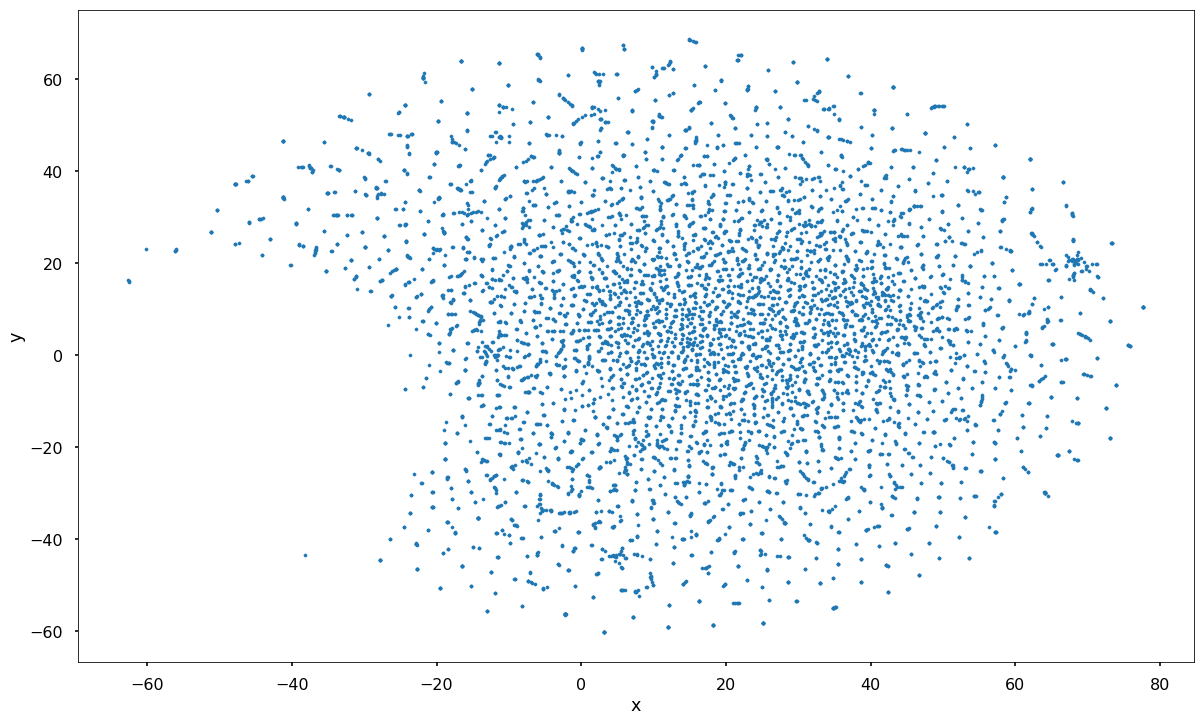

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context("poster")

points.plot.scatter("x", "y", s=10, figsize=(20, 12))

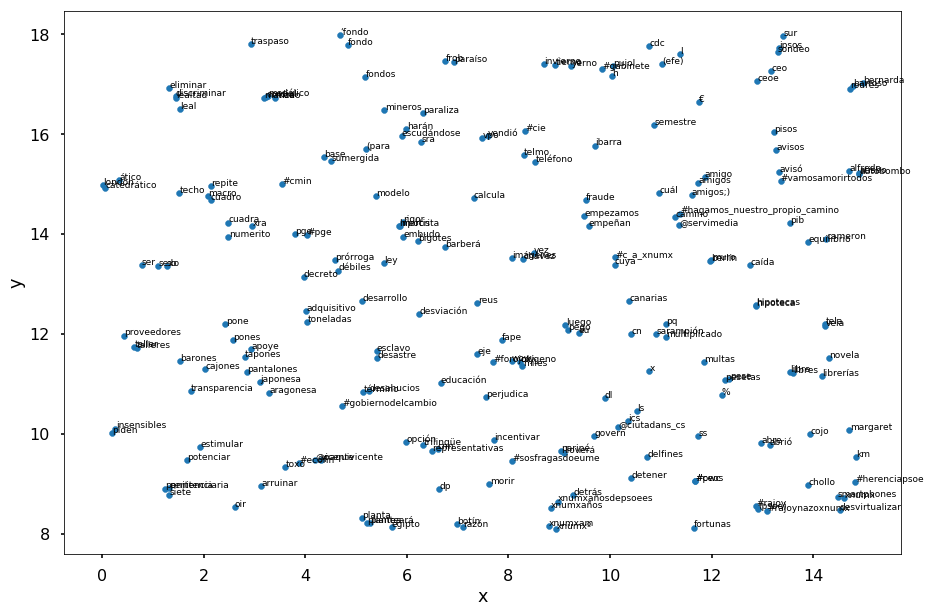

In [19]:
def plot_region (x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1]) 
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(15, 10))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=9)
    
plot_region(x_bounds=(0, 15), y_bounds=(8, 18))

In [22]:
modelo.wv.most_similar("futbol")

[('futboleros', 0.7976787090301514),
 ('#tomacomentariofutbolero', 0.7009741067886353),
 ('fútbol', 0.6434677839279175),
 ('golazo', 0.6074306964874268),
 ('sergio', 0.6059077978134155),
 ('k', 0.5982542634010315),
 ('shakirahq', 0.5758806467056274),
 ('shakira', 0.5680345892906189),
 ('bagdad', 0.5556315183639526),
 ('llull', 0.5443958640098572)]